In [1]:
import sys
import time
import numpy as np
import pandas as pd
import pennylane as qml
import seaborn as sns
from dwave_qbsolv import QBSolv
from matplotlib import pyplot as plt
from pennylane import qaoa
import copy
import progressbar
import os
import os.path
from qiskit import IBMQ

import dimod.utilities

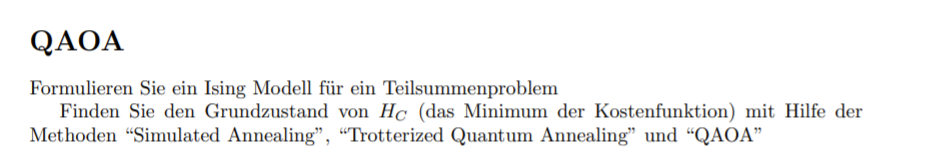

In [2]:
#complex
'''
number_set = [5, 3, 1, 4, 10]
S = 15
'''

'\nnumber_set = [5, 3, 1, 4, 10]\nS = 15\n'

In [41]:
#easy
number_set = [1,2,3]
S = 3

In [42]:
def fill_QUBO(number_set, S):
    n = len(number_set)
    QUBO = np.zeros((n, n))
    
    #Lin Terms
    for i in range(n):
        w_i = number_set[i]
        QUBO[i][i] = w_i*w_i-2*S*w_i
        #print(w_i*w_i-2*S*w_i)
        
        #Quadratische Terms
        for j in range(i+1, n, 1):
            w_j = number_set[j]
            QUBO[i][j] = 2*w_i*w_j
    return QUBO

In [43]:
QUBO = fill_QUBO(number_set, S)

In [44]:
QUBO

array([[-5.,  4.,  6.],
       [ 0., -8., 12.],
       [ 0.,  0., -9.]])

In [45]:
n = len(number_set)

qubo_d = {}
x1 = 0
while x1 < n:
    x2 = x1
    while x2 < n:
        qubo_d[(x1, x2)] = int(QUBO[x1][x2])
        x2 += 1
    x1 += 1
    
print(qubo_d)

{(0, 0): -5, (0, 1): 4, (0, 2): 6, (1, 1): -8, (1, 2): 12, (2, 2): -9}


In [46]:
isingX = dimod.qubo_to_ising(qubo_d, 0)
print(isingX)
(linear, quadratic, _) = isingX
print("\n")
print(linear)
print("\n")
print(quadratic)

({0: 0.0, 1: 0.0, 2: 0.0}, {(0, 1): 1.0, (0, 2): 1.5, (1, 2): 3.0}, -5.5)


{0: 0.0, 1: 0.0, 2: 0.0}


{(0, 1): 1.0, (0, 2): 1.5, (1, 2): 3.0}


In [47]:
n_qubits = n
wires = range(n_qubits)
depthX = 1

In [48]:
linear_coefficents = [linear[i] for i in range(n_qubits) if i in linear]
linear_gates = [qml.PauliZ(i) for i in range(n_qubits) if i in linear]
quadratic_coefficents = [quadratic[(i, j)] for i in range(n_qubits) for j in range(n_qubits) if (i, j) in quadratic]
quadratic_gates = [qml.PauliZ(i) @ qml.PauliZ(j) for i in range(n_qubits) for j in range(n_qubits) if
                       (i, j) in quadratic]

coefficents = linear_coefficents + quadratic_coefficents
gates = linear_gates + quadratic_gates

cost_h = qml.Hamiltonian(coefficents, gates)

In [49]:
print(cost_h)

  (0.0) [Z0]
+ (0.0) [Z1]
+ (0.0) [Z2]
+ (1.0) [Z0 Z1]
+ (1.5) [Z0 Z2]
+ (3.0) [Z1 Z2]


In [50]:
mixer_h = qaoa.x_mixer(0)
for i in range(n_qubits - 1):
    mixer_h += qaoa.x_mixer(i + 1)

In [51]:
print(mixer_h)

  (1) [X0]
+ (1) [X1]
+ (1) [X2]


In [52]:
def qaoa_layer(gamma, alpha):
    
    qaoa.mixer_layer(alpha, mixer_h)
    qaoa.cost_layer(gamma, cost_h)

In [53]:
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depthX, params[0], params[1])

In [54]:
token = '1c854f9916477c15b8ef30c1243313b67e739cfc30f10cd741d7ad787f102bca0f0e60f474acc939c10761884cc75eff19910dbc5fb2e045c1f56dc1b274d553'

In [55]:
dev = qml.device("qiskit.ibmq", wires=wires, ibmqx_token=token)

IBMQAccountError: 'An IBM Quantum Experience account is already in use for the session.'

In [56]:
cost_function = qml.ExpvalCost(circuit, cost_h, dev, optimize=True)

In [57]:
optimizer = qml.AdamOptimizer() # qml.AdagradOptimizer() #qml.GradientDescentOptimizer() 

In [58]:
params = [[1.5], [1.5]] #pre-optimized parameters

print("Start parameters: ", params)

Start parameters:  [[1.5], [1.5]]


In [59]:
steps = 0

optimizerType = type(optimizer).__name__
path = os.getcwd()
print(path)
savestring = path + f"\{optimizerType}_{depthX}_{steps}_{params}"
print(savestring)

C:\Users\potap\PycharmProjects\quantum-walks-away\QW\QC Praktitum Kranzlmüller\12.10
C:\Users\potap\PycharmProjects\quantum-walks-away\QW\QC Praktitum Kranzlmüller\12.10\AdamOptimizer_1_0_[[1.5], [1.5]]


In [60]:
for i in progressbar.progressbar(range(steps), redirect_stdout=True):
    params = optimizer.step(cost_function, params)
    print(' | New parameters:', params)
    print("\n", dev.num_executions)
    f = open(savestring + "paramsQuicksaveIBM.txt", 'a+')
    f.write("parameter quicksave stepnumber " + str(i) + ": " + str(params) + "\n\n")
    f.close()

print("\n")
print("Optimal parameters: ", params)

- |#                                                  | 0 Elapsed Time: 0:00:00




Optimal parameters:  [[1.5], [1.5]]


In [61]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

WireError: Did not find some of the wires <Wires = [2]> on device with wires <Wires = [0, 1]>.

ValueError: shape mismatch: objects cannot be broadcast to a single shape

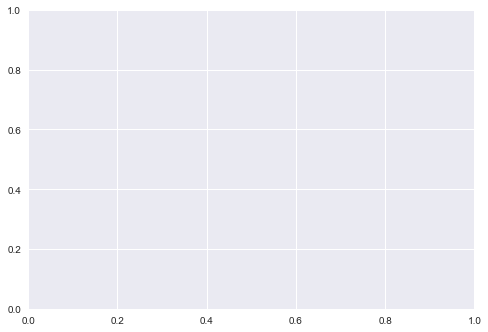

In [62]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.savefig(savestring + ".png")
plt.show()

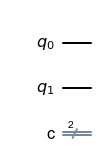

In [64]:
dev._circuit.draw(output="mpl")

In [ ]:
  (-6.0) [Z2]
+ (-3.0) [Z0]
+ (-1.5) [Z1]
+ (1.0) [Z0 Z1]
+ (2.0) [Z1 Z2]
+ (4.0) [Z0 Z2]

In [ ]:
{(0, 1): 1.0, (0, 2): 4.0, (1, 2): 2.0}

## QBSolv

In [41]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import networkx as nx
import plotly.express as px
import seaborn as sns
import random

from dwave_qbsolv import QBSolv

import dimod
import neal
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.system import LeapHybridSampler

In [42]:
#QBSolve
def on_QBsolve(qubo_dictionary):
    result = QBSolv().sample_qubo(qubo_dictionary)
    return result

In [45]:
on_QBsolve(qubo_d)

SampleSet(rec.array([([1, 1, 0], -9., 23), ([0, 0, 1], -9., 28)],
          dtype=[('sample', 'i1', (3,)), ('energy', '<f8'), ('num_occurrences', '<i4')]), Variables([0, 1, 2]), {}, 'BINARY')